<h1>ETL planning for Brazillian Interest Rate and Inflation Rate Data Analysis</h1> 
Author: <a href=https://www.linkedin.com/in/mailson-p-92909928a/> Mailson Vieira Passos <a/>

<hr>

<h2>Table of content</h2>
<div class="alert alert-block alert-danger" style="background-color: #ffffee; margin-top: 20px; margin-left: 10px; color: black; font-size: 15px">
    <ol>
        <li><a href="#Motivation">Motivation</a></li>
        <li><a href="#Objective">Objective</a></li>
        <li><a href="#Requirements">Requirements</a></li>
        <li><a href="#ETL">ETL + pre-analysis </a></li>
            <ol>
                <li><a href="#Selic">Selic</a></li>
                <li><a href="#IPCA">IPCA</a></li>
            </ol>    
    </ol>

</div>

<h2><span id='Motivation'>Motivation</span></h2>
Lately, Brazil's interest rate has been increasing non-stop and I wanted to understand more about it. I also wanted to apply some statistical knowlegdge that I recently acquired to analyze it.

Let's begin with some definitions
</ul>

What is the Selic (interest rate)?

> The Selic rate is the reference interest rate for the Brazilian economy. It influences other rates, such as those used in loans, financing and investments. Setting a target for the Selic rate is the main monetary policy instrument used by the Banco Central do Brasil (BCB) to control inflation.  
> The Selic rate is calculated by taking the average interest rate charged on overnight operations collateralized by federal government securities traded in the local market. The BCB carries out operations in the market of government securities so that the Selic rate is in line with the target set by the Monetary Policy Committee (Copom) of the BCB   
\
Source: <a href = 'https://www.bcb.gov.br/en/monetarypolicy/selicrate'> <b>Brazillian Central Bank</b> </a>

What is the IPCA?

>The National System of Consumer Price Indexes - SNIPC continuously and systematically produces the Extended National Consumer Price Index - IPCA, aimed at measuring the inflation rate for a group of products and services from retail trade, relative to household expenditure. That income range was created in order to guarantee a 90% coverage of families living in urban areas included in the National System of Consumer Price Indexes - SNIPC.   (IBGE).  
\
Source: <a href = 'https://www.ibge.gov.br/en/statistics/economic/prices-and-costs/17129-extended-national-consumer-price-index.html?=&t=o-que-e'> <b>Brazilian Institute of Geography and Statistics (IBGE)</b> </a>


<hr>

<h2><span id='Objective'>Objective</span></h2>
<ul>
    <li>Extract the interest rate data which is available at <a href=https://www.bcb.gov.br/controleinflacao/historicotaxasjuros>Banco Central do Brasil</a> and the inflation rate that is available at <a href=https://www.ibge.gov.br/estatisticas/economicas/precos-e-custos/9256-indice-nacional-de-precos-ao-consumidor-amplo.html?=&t=downloads>IBGE</a></li>
    <li>Do the necessary transformations</li>
    <li>Pre-analysis</li>
</ul>

<hr>
<h2>Requirements</h2>

```python
!pip install pandas==2.0.0
!pip install numpy==1.26.1
!pip install matplotlib==3.8.0
!pip install seaborn==0.13.2
!pip install requests==2.31.0
```
<hr>

<h2><span id='ColetaTransf'></span>Extração, transformação e pré-análise</h2>

<h3><span id='Selic'></span>1. Selic</h3>
The 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
selic_data_file = r'dados/selic.tsv'

In [3]:
selic_df = pd.read_csv(
    selic_data_file,
    header = None,
    sep = '\t'
)
selic_cols =[
    'reuniao_num',
    'reuniao_data',
    'reuniao_vies',
    'periodo_vigencia',
    'meta_selic_pctaa',
    'tban_pctam',
    'taxa_selic_pct',
    'taxa_selic_pctaa'
]
selic_df.columns = selic_cols
selic_df.head()

,reuniao_num,reuniao_data,reuniao_vies,periodo_vigencia,meta_selic_pctaa,tban_pctam,taxa_selic_pct,taxa_selic_pctaa
0,269ª,19/03/2025,NaN,20/03/2025 -,"14,25",NaN,NaN,NaN
1,268ª,29/01/2025,NaN,30/01/2025 - 19/03/2025,"13,25",NaN,"1,63","13,15"
2,267ª,11/12/2024,NaN,12/12/2024 - 29/01/2025,"12,25",NaN,"1,51","12,15"
3,266ª,06/11/2024,NaN,07/11/2024 - 11/12/2024,"11,25",NaN,"0,97","11,15"
4,265ª,18/09/2024,NaN,19/09/2024 - 06/11/2024,"10,75",NaN,"1,42","10,65"


<h4>Dataset schema</h4>

| Variable                  | Description                          |
|---------------------------|-------------------------------------|
| reuniao_num               | Ordinal classification of the Copom' meeting    |
| reuniao_data              | Meeting's date                                 |
| reuniao_vies              | The indicated bias for the upcoming change in the target interest rate. This change may be implemented in accordance with the bias, at any time.                         |
| periodo_vigencia          | The time period which the target interest rate is /was in place.  |                                  
| meta_selic_pctaa          | The established annual interest rate, set as a reference  |
| tban_pctam                | The Brazillian Central Bank Assistance Rate is an instrument that is charged on loans when banks do not have government bonds to offer as collateral or when they exceed the credit limits of the line that uses the Central Bank's Basic Rate.   |
| taxa_selic_pct            | The weighted and adjusted average of the daily financing transactions calculated by the SELIC (a Special Settlement and Custody System) to the one-day repurchase operations backed by government bonds and accumulated over the period. |
| taxa_selic_pctaa          | The annual interest rate based on 252 working days   |

Some additional information that needs to be addded: Brazil has the interest rate (called Selic rate) as well as a  target interest rate called 'Meta rate'. While the latter is computed and published by the The Monetary Policy Committee (COPOM), the former is a result of the daily SELIC (Special Settlement and Custody System) operations, which is conducted for financial institutions.

The column periodo_vigencia contains both the end and start date, so we will split it nto two columns: start date and end date. Before doing this, we need to standardize the formatting because in the first row is missing an end date, and the string ends after the hyphen. Therefore we will add a spece after the hyphen in the first column and then split it into two columns. The first will be named vigencia_inicio(start_date) and the second, vigencia_fim(end_date).

In [4]:
selic_df.at[0, 'periodo_vigencia'] = selic_df.at[0,'periodo_vigencia'] + ' '
selic_df[['vigencia_inicio', 'vigencia_fim']] = selic_df['periodo_vigencia'].str.split(' - ', expand =  True)
selic_df.head()

,reuniao_num,reuniao_data,reuniao_vies,periodo_vigencia,meta_selic_pctaa,tban_pctam,taxa_selic_pct,taxa_selic_pctaa,vigencia_inicio,vigencia_fim
0,269ª,19/03/2025,NaN,20/03/2025 -,"14,25",NaN,NaN,NaN,20/03/2025,
1,268ª,29/01/2025,NaN,30/01/2025 - 19/03/2025,"13,25",NaN,"1,63","13,15",30/01/2025,19/03/2025
2,267ª,11/12/2024,NaN,12/12/2024 - 29/01/2025,"12,25",NaN,"1,51","12,15",12/12/2024,29/01/2025
3,266ª,06/11/2024,NaN,07/11/2024 - 11/12/2024,"11,25",NaN,"0,97","11,15",07/11/2024,11/12/2024
4,265ª,18/09/2024,NaN,19/09/2024 - 06/11/2024,"10,75",NaN,"1,42","10,65",19/09/2024,06/11/2024


We can now drop the periodo_vigencia column

In [5]:
selic_df = selic_df.drop(['periodo_vigencia'], axis = 1)
selic_cols = selic_df.columns

It time to check if we have missing data?

In [6]:
selic_df.isnull().sum().sum()

340

Quite a lot. Let's check the data types.

In [7]:
selic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   reuniao_num       277 non-null    object
 1   reuniao_data      277 non-null    object
 2   reuniao_vies      187 non-null    object
 3   meta_selic_pctaa  277 non-null    object
 4   tban_pctam        29 non-null     object
 5   taxa_selic_pct    276 non-null    object
 6   taxa_selic_pctaa  276 non-null    object
 7   vigencia_inicio   277 non-null    object
 8   vigencia_fim      277 non-null    object
dtypes: object(9)
memory usage: 19.6+ KB


Every column are object typed. This may mean that every column only contains strings, or they are mixed typed. We will check this with the following function.

In [8]:
def dfcols_type(df: pd.DataFrame, filter: bool | None = None) -> dict[str, set]:
    '''Show the data types in each column of a pandas' Dataframe
    
    Parametros:
    -----
    df: pd.DataFrame
        Dataframe to be analysed.
    filter: bool, optional
        If True, display only the column containing data with two or more types.
        
    Return:
    -----
    df_coltype: dict
        A python dictionary containing the column name and the types od the data in the column.
    '''
    df_coltypes = {}
    df_cols = df.columns 

    for col in df_cols:
        coltypes= set(df[col].apply(lambda x: type(x)))

        if filter and len(coltypes) < 2:
            continue
        df_coltypes[col] = coltypes

    return df_coltypes

In [9]:
dfcols_type(selic_df)

{'reuniao_num': {str},
 'reuniao_data': {str},
 'reuniao_vies': {float, str},
 'meta_selic_pctaa': {str},
 'tban_pctam': {float, str},
 'taxa_selic_pct': {float, str},
 'taxa_selic_pctaa': {float, str},
 'vigencia_inicio': {str},
 'vigencia_fim': {str}}

What we get from the output of the above function is that some column are mixed-typed and the those that aren't are correct typed.

So we need to set the correct types for each column with mixed types. 

<table>
    <thead>
        <tr>
            <th>Variável</th>
            <th>Tipo</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <th>reuniao_num</th>
            <td>Keep as string.</td>
        </tr>
        <tr>
            <th>reuniao_data</th>
            <td>Cast as datetime.</td>
        </tr>
        <tr>
            <th>reuniao_vies</th>
            <td>Keep as string. </td>
        </tr>
        <tr>
            <th>meta_selic_pctaa</th>
            <td>Cast as float. </td>
        </tr>
        <tr>
        <th>tban_pctam</th>
            <td>Cast as float. </td>
        </tr>
        <tr>
            <th>taxa_selic_porcento</th>
            <td>Cast as float. </td>
        </tr>
        <tr>
            <th>taxa_selic_pctaa</th>
            <td>Cast as float. </td>
        </tr>
        <tr>
            <th>vigencia_inicio</th>
            <td>Cast as datetime. </td>
        </tr>
        <tr>
            <th>vigencia_fim</th>
            <td>Cast as datetime. </td>
        </tr>
    </tbody>
</table>


Furthermore, we will add today's date in th first row of the column vigencia_fim. We also need to change the decimal sign, which is a comma in Brazil to a dot.

In [10]:
num_cols = len(selic_cols)

selic_df.at[0, 'vigencia_fim'] = pd.Timestamp.today().strftime('%d/%m/%Y')

for ii in range(1, num_cols):
    if ii in range(3, 7):
        selic_df[selic_cols[ii]] = selic_df[selic_cols[ii]].str.replace(',', '.') 
        selic_df[selic_cols[ii]] = pd.to_numeric(selic_df[selic_cols[ii]])
    elif ii == 2:
        continue
    else:
        selic_df[selic_cols[ii]] = pd.to_datetime(selic_df[selic_cols[ii]], format="%d/%m/%Y")
selic_df.head()

,reuniao_num,reuniao_data,reuniao_vies,meta_selic_pctaa,tban_pctam,taxa_selic_pct,taxa_selic_pctaa,vigencia_inicio,vigencia_fim
0,269ª,2025-03-19,NaN,14.25,NaN,NaN,NaN,2025-03-20,2025-04-06
1,268ª,2025-01-29,NaN,13.25,NaN,1.63,13.15,2025-01-30,2025-03-19
2,267ª,2024-12-11,NaN,12.25,NaN,1.51,12.15,2024-12-12,2025-01-29
3,266ª,2024-11-06,NaN,11.25,NaN,0.97,11.15,2024-11-07,2024-12-11
4,265ª,2024-09-18,NaN,10.75,NaN,1.42,10.65,2024-09-19,2024-11-06


In [11]:
selic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   reuniao_num       277 non-null    object        
 1   reuniao_data      277 non-null    datetime64[ns]
 2   reuniao_vies      187 non-null    object        
 3   meta_selic_pctaa  277 non-null    float64       
 4   tban_pctam        29 non-null     float64       
 5   taxa_selic_pct    276 non-null    float64       
 6   taxa_selic_pctaa  276 non-null    float64       
 7   vigencia_inicio   277 non-null    datetime64[ns]
 8   vigencia_fim      277 non-null    datetime64[ns]
dtypes: datetime64[ns](3), float64(4), object(2)
memory usage: 19.6+ KB


Now we can recheck the missing values by each column

In [12]:
selic_df.isnull().sum()[selic_df.isnull().sum() > 0]

reuniao_vies         90
tban_pctam          248
taxa_selic_pct        1
taxa_selic_pctaa      1
dtype: int64

The column reuniao_vies has a lot of missing data while it should be a str typed column. So we will replace the NaN with the string 'n/a' to indicate the data is missing.

In [13]:
selic_df['reuniao_vies'] = selic_df['reuniao_vies'].replace(np.nan, 'n/a')

The missing data of the columns taxa_selic_pct and taxa_selic_pctaa corresponds to the first row of the dataset. This occurs  because the target (meta) is stablished in the first place for the inter Copom reunion period. Later, after the reunion, the selic rate is computed and announced

The missing data in the colum tban may be explained because the TBAN's information on <a href='https://www.bcb.gov.br/en/monetarypolicy/interestrates'>Brazillian Central Bank's website</a>, which states it was discontinued on March 4, 1994.      

In [14]:
selic_df.loc[(selic_df['reuniao_data'] > '1999-01') & (selic_df['reuniao_data'] < '1999-05'), ['reuniao_data', 'tban_pctam']]

,reuniao_data,tban_pctam
240,1999-04-28,NaN
241,1999-04-14,NaN
242,1999-04-05,NaN
243,1999-03-25,NaN
244,1999-03-04,NaN
245,1999-01-18,41.0


As of 4th March, we don't have more TBAN.
We will now check reuniao_vies

In [15]:
selic_df[selic_df['reuniao_vies'] == 'n/a']

,reuniao_num,reuniao_data,reuniao_vies,meta_selic_pctaa,tban_pctam,taxa_selic_pct,taxa_selic_pctaa,vigencia_inicio,vigencia_fim
0,269ª,2025-03-19,n/a,14.25,NaN,NaN,NaN,2025-03-20,2025-04-06
1,268ª,2025-01-29,n/a,13.25,NaN,1.63,13.15,2025-01-30,2025-03-19
2,267ª,2024-12-11,n/a,12.25,NaN,1.51,12.15,2024-12-12,2025-01-29
3,266ª,2024-11-06,n/a,11.25,NaN,0.97,11.15,2024-11-07,2024-12-11
4,265ª,2024-09-18,n/a,10.75,NaN,1.42,10.65,2024-09-19,2024-11-06
...,...,...,...,...,...,...,...,...,...
272,5ª,1996-10-23,n/a,1.78,1.90,1.80,25.27,1996-11-01,1996-11-30
273,4ª,1996-09-23,n/a,1.82,1.93,1.86,23.48,1996-10-01,1996-10-31
274,3ª,1996-08-21,n/a,1.88,NaN,1.90,25.40,1996-09-01,1996-09-30
275,2ª,1996-07-30,n/a,1.90,NaN,1.97,25.01,1996-08-01,1996-08-31


Quickly examining the data, the bias instrument appears to have a limited use.

In [16]:
selic_df['reuniao_vies'].value_counts().to_frame()

,count
reuniao_vies,
sem viés,168
n/a,90
baixa,18
alta,1


In [17]:
selic_df.shape

(277, 9)

Only 18 lines in the entire datase have reuniao_vies as value: baixa, which means the interest rate will be lowered at a later date.

In [18]:
selic_df[['reuniao_num', 'reuniao_data', 'reuniao_vies', 'meta_selic_pctaa', 'vigencia_inicio']][selic_df['reuniao_vies'].str.contains('baixa|alta')]

,reuniao_num,reuniao_data,reuniao_vies,meta_selic_pctaa,vigencia_inicio
187,82ª,2003-03-19,alta,26.50,2003-03-20
195,74ª,2002-08-21,baixa,18.00,2002-08-22
197,72ª,2002-06-19,baixa,18.50,2002-06-20
209,60ª,2001-06-20,baixa,18.25,2001-06-21
221,Pres. (9),2000-07-07,baixa,17.00,2000-07-10
222,48ª,2000-06-20,baixa,17.50,2000-06-21
225,Pres. (9),2000-03-28,baixa,18.50,2000-03-29
226,45ª,2000-03-22,baixa,19.00,2000-03-23
231,40ª,1999-10-06,baixa,19.00,1999-10-07
235,36ª,1999-06-23,baixa,21.00,1999-06-24


Out of a total of 272 meetings that were held, only 19 had used the bias instrument. Of this 18 had a downward bias. Moreover, reuniao_num have a Pres.9 string, which might have an associated meaning.

In [19]:
pres_ocorr = selic_df[['reuniao_data', 'reuniao_num', 'reuniao_vies']][selic_df['reuniao_num'].str.contains('Pres.')]
pres_ocorr

,reuniao_data,reuniao_num,reuniao_vies
221,2000-07-07,Pres. (9),baixa
225,2000-03-28,Pres. (9),baixa
236,1999-06-08,Pres. (9),baixa
238,1999-05-12,Pres. (9),baixa
239,1999-05-07,Pres. (9),baixa
240,1999-04-28,Pres. (9),baixa
242,1999-04-05,Pres. (9),baixa
243,1999-03-25,Pres. (9),baixa


We may notice that 'Pres.(9)' only occurred 8 times and all the ocorrence happened with a downward bias (baixa).

Refering back at the columns description, we can recall that once the bias is stablished in a meeting, a change can be made at any time. Note that between the 33rd and the 34th meeting there were 2 changes in the target, and the string Pres.(9) show that there wasn't a new meeting but rather new decision of the Central Bank to change the selic. Because of this, I am going to create a new column to accomodate all dates when no meeting was held. 

In [20]:
selic_df['data_comunicao_decisao_vies'] = selic_df.loc[pres_ocorr.index, 'reuniao_data'].reindex(np.arange(0, len(selic_df)), fill_value = pd.NaT)
selic_df.loc[pres_ocorr.index, 'reuniao_data'] = pd.NaT
selic_df['data_comunicao_decisao_vies']

0     NaT
1     NaT
2     NaT
3     NaT
4     NaT
       ..
272   NaT
273   NaT
274   NaT
275   NaT
276   NaT
Name: data_comunicao_decisao_vies, Length: 277, dtype: datetime64[ns]

In [ ]:
The last time the bias instrument was used, was in March 2003. 

Por outro lado, a última vez que tivemos viés foi em março de 2003. Será que desde então não houve mais necessidade de estabelecer viés? Aparentemente, até o final 2017 não houve, mas em dezembro de 2017 o Copom resolveu <a href= 'https://exame.com/economia/bc-altera-regulamento-do-copom-e-extingue-o-vies-para-selic/'>extinguir o instrumento viés de suas reuniões </a> e por isso temos a string n/a.

In [21]:
selic_df[['reuniao_data', 'reuniao_num', 'reuniao_vies']][selic_df['reuniao_vies'] == 'n/a'].index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
       257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270,
       271, 272, 273, 274, 275, 276],
      dtype='int64')

Note que o índice salta de 53 para 241. 

In [22]:
selic_df.loc[[53,54,240,241], :]

,reuniao_num,reuniao_data,reuniao_vies,meta_selic_pctaa,tban_pctam,taxa_selic_pct,taxa_selic_pctaa,vigencia_inicio,vigencia_fim,data_comunicao_decisao_vies
53,216ª,2018-08-01,n/a,6.5,NaN,0.84,6.40,2018-08-02,2018-09-19,NaT
54,215ª,2018-06-20,n/a,6.5,NaN,0.74,6.40,2018-06-21,2018-08-01,NaT
240,Pres. (9),NaT,baixa,32.0,NaN,0.77,31.91,1999-04-29,1999-05-07,1999-04-28
241,34ª,1999-04-14,baixa,34.0,NaN,1.05,33.92,1999-04-15,1999-04-28,NaT


Do site do bcb: O viés foi introduzido pela Circular 2.868, de 4/3/1999, e extinto pela Circular 3.868, de 19/12/2017. Portanto temos consistência.

Podemos ainda extrair mais informação da coluna reuniao_num, pois cada elemento dela pode conter ou não o termo 'ex', que significa que a reunião ocorrida foi extraordinária. Vamos verificar

In [23]:
selic_df[['reuniao_data', 'reuniao_num']][selic_df['reuniao_num'].str.contains('ex')]

,reuniao_data,reuniao_num
193,2002-10-14,76ª ex. (8)
249,1998-09-10,28ª ex. (8)
259,1997-10-30,18ª ex. (8)


Assim temos que a última reunião extraordinária registrada foi dia 14 de outubro de 2002, há aproximadamente 22 anos atrás. No site <a href= 'https://www.onze.com.br/blog/reuniao-copom/' a>Onze</a>, é dito que o Presidente do Banco Central tem o poder de convocar uma reunião extraordinária, em caso de alterações bruscas e de grande relevância no cenário macroeconômico. Logo, podemos inferir, que  não houve mais alterações bruscas que fizessem esse tipo de reunião ser convocada. Não consegui achar mais informações sobre isso.

Vamos conferir se as datas estão corretas, ou seja, se estão distribuídas de forma estritamente crescente (ou decrescente, dependendo da ordenação). Para isso, fazemos a diferença entre a séries e a séries deslocada em uma unidade e verificamos se é maior que zero

In [24]:
data_cols = ['reuniao_data', 'vigencia_inicio', 'vigencia_fim']
col_datas = []

for col in data_cols:
    col_datas.append([col, ((selic_df[col] - selic_df[col].shift(1)) >= pd.Timedelta(0)).any()])

pd.DataFrame(col_datas, columns = ['coluna', 'nao_estrita_decrescente?']).set_index('coluna')

,nao_estrita_decrescente?
coluna,
reuniao_data,False
vigencia_inicio,True
vigencia_fim,True


Estranhamente a coluna vigencia_inicio e a coluna vigencia_fim retornaram true, o que quer dizer que temos um problema com datas. Vamos estudar rapidamente esse problema

In [25]:
datas_problemas = (selic_df['vigencia_inicio'] - selic_df['vigencia_inicio'].shift(1)) >= pd.Timedelta(0)
idxs_problemas = selic_df['vigencia_inicio'][datas_problemas]
idxs_problemas

260   1997-11-01
Name: vigencia_inicio, dtype: datetime64[ns]

Temos somente uma data que está onde não deveria. Vamos olhar a vizinhança

In [26]:
selic_df.loc[idxs_problemas.index[0] - 2 : idxs_problemas.index[0] + 2, :]

,reuniao_num,reuniao_data,reuniao_vies,meta_selic_pctaa,tban_pctam,taxa_selic_pct,taxa_selic_pctaa,vigencia_inicio,vigencia_fim,data_comunicao_decisao_vies
258,19ª,1997-11-19,n/a,2.90,3.15,2.97,39.87,1997-12-01,1997-12-31,NaT
259,18ª ex. (8),1997-10-30,n/a,3.05,3.23,3.18,45.67,1997-10-31,1997-11-30,NaT
260,17ª (7),1997-10-22,n/a,1.00,1.00,3.04,45.90,1997-11-01,1997-11-30,NaT
261,16ª,1997-09-17,n/a,1.58,1.78,1.53,19.05,1997-10-01,1997-10-30,NaT
262,15ª,1997-08-20,n/a,1.58,1.78,1.59,19.81,1997-09-01,1997-09-30,NaT


Realmente temos algo estranho, pois depois do dia 1 de novembro, voltamos para o dia 31 de outubro, isso olhando a coluna vigencia_inicio. Com um olhar mais atento, percebemos que no dia 30 de outubro houve uma reunião extraordinária, mas infelizmente, no site do BCB, somente encontrei as atas a partir da 21º reunião. Podemos supor que a reunião do dia 30 sustou os efeitos da reunião anterior, aumentou a meta e antecipou o início da nova meta, haja vista que tudo foi feito numa reunião que ocorreu devido a alterações bruscas no cenário macroeconômico. Pesquisando mais a fundo, encontrei que nesse período houve o crash da bolsa de valores de Hong Kong (<a href = 'https://www1.folha.uol.com.br/fol/retro97/retro97_economia1.htm'>ref</a>) dia 29, o que explica a urgência.

Outra informação que consta no site do BCB é que as reuniões são geralmente realizadas a cada 45 dias (<a href = 'https://www.bcb.gov.br/controleinflacao/copom'>site BCB</a>). Vamos checar

In [27]:
dias_entre_reunioes =  (selic_df['reuniao_data'].shift(1) - selic_df['reuniao_data']).dropna()
dias_entre_reunioes

1     49 days
2     49 days
3     35 days
4     49 days
5     49 days
        ...  
272   35 days
273   30 days
274   33 days
275   22 days
276   34 days
Name: reuniao_data, Length: 263, dtype: timedelta64[ns]

Como podemos ver, não é verdade que as reuniões ocorrem a cada 45 dias. Vamos rapidamente ver como esses dados se distribuem

[]

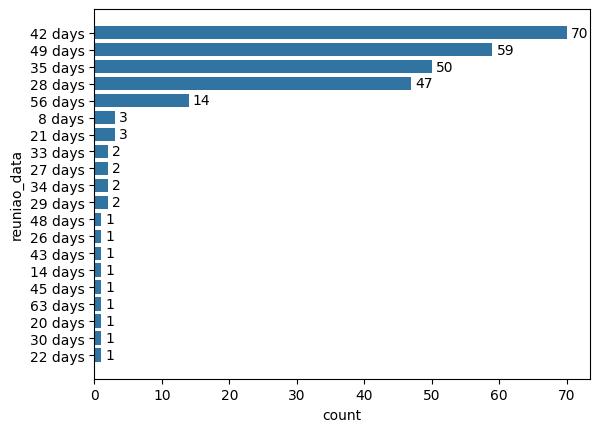

In [28]:
fig, ax = plt.subplots()
sns.barplot(dias_entre_reunioes.value_counts(), orient = 'h', ax = ax)
ax.bar_label(ax.containers[0], fmt=lambda x: int(x), padding = 3)
plt.plot()

A maior ocorrência de dias entre reuniões foram 42 dias, seguido por 49 dias. Mas será que pelo menos em média, as reuniões ocorrem a cada 45 dias?

In [29]:
dias_entre_reunioes.agg(['mean', 'median']).to_frame()

,reuniao_data
mean,39 days 06:12:19.163498099
median,42 days 00:00:00


A média foi 39 dias enquanto a mediana foi de 42 dias. Claramente o fato de ter havido 8 dias entre reuniões fez com que a média diminuísse. Vamos estudar melhorar a distribuição dos dados.

<Axes: ylabel='reuniao_data'>

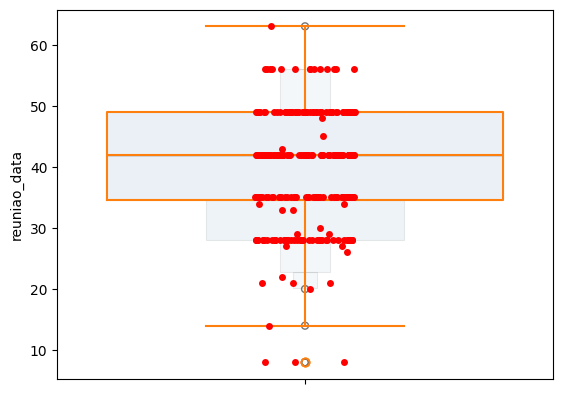

In [30]:
dias_entre_reunioes = (dias_entre_reunioes.astype('str').str.split().str[0]).astype('int')
ax = sns.boxenplot(dias_entre_reunioes, alpha= 0.1)
sns.boxplot(dias_entre_reunioes, fill = False, ax = ax)
sns.stripplot(dias_entre_reunioes, color = 'red', ax = ax)

From the above plot, we can tell at least three outliers. These outliers are clearly related to the 8 days between meetings. But to be sure, let's identify them.

In [17]:
def boxplot_outlier_filtro(data: pd.Series) -> pd.Series:
    '''Returns a filter to isolate the outliers
    
    Parameters:
    ---
    data: pd.Series
        Data to be filtered

    Returns:
    ---
    pd.Series:
        Boolean series where True is an outlier and False isn't
    '''
    data_mean = data.mean()
    data_quartsup = data.quantile(.75)
    data_quartinf = data.quantile(.25)
    data_interquartile = data_quartsup - data_quartinf
    fator = 1.5

    filtro_sup = (data > data_quartinf + (fator * data_interquartile)) 
    filtro_inf = (data < data_quartinf - (fator * data_interquartile)) 

    return filtro_sup | filtro_inf

In [32]:
intrareunioes_outliers = dias_entre_reunioes[boxplot_outlier_filtro(dias_entre_reunioes)].to_frame()
intrareunioes_outliers = intrareunioes_outliers.rename(columns = {intrareunioes_outliers.columns[0]: 'intrareuniao_outlier'})
intrareunioes_outliers

,intrareuniao_outlier
58,63
193,8
250,8
260,8


In reality, we have 4 outliers. I can't deny that 8 days between meeting makes me relate them to extraordinary meetings.

In [18]:
intrareuniao_outlier_filtro = boxplot_outlier_filtro(dias_entre_reunioes).reindex(np.arange(0, len(selic_df)), fill_value = False)
selic_df[intrareuniao_outlier_filtro]

NameError: name 'dias_entre_reunioes' is not defined

Vamos melhorar mais um pouco avaliando a vizinhança

In [34]:
intrareunioes_outliers_idx = intrareunioes_outliers.index
intrareunioes_outliers_idxvizinhos = []

for i in intrareunioes_outliers_idx:
    if i > 0 and i <= len(selic_df):
        intrareunioes_outliers_idxvizinhos.extend([i - 1, i, i + 1])

selic_df.loc[intrareunioes_outliers_idxvizinhos, :]

,reuniao_num,reuniao_data,reuniao_vies,meta_selic_pctaa,tban_pctam,taxa_selic_pct,taxa_selic_pctaa,vigencia_inicio,vigencia_fim,data_comunicao_decisao_vies
57,212ª,2018-02-07,n/a,6.75,NaN,0.72,6.65,2018-02-08,2018-03-21,NaT
58,211ª,2017-12-06,sem viés,7.00,NaN,1.15,6.90,2017-12-07,2018-02-07,NaT
59,210ª,2017-10-25,sem viés,7.50,NaN,0.80,7.40,2017-10-26,2017-12-06,NaT
192,77ª,2002-10-22,sem viés,21.00,NaN,1.44,20.90,2002-10-23,2002-11-20,NaT
193,76ª ex. (8),2002-10-14,sem viés,21.00,NaN,0.53,20.90,2002-10-15,2002-10-22,NaT
194,75ª,2002-09-18,sem viés,18.00,NaN,1.18,17.90,2002-09-19,2002-10-14,NaT
249,28ª ex. (8),1998-09-10,n/a,19.00,49.75,2.58,40.18,1998-09-11,1998-10-07,NaT
250,27ª,1998-09-02,n/a,19.00,29.75,0.45,25.49,1998-09-03,1998-09-10,NaT
251,26ª,1998-07-29,n/a,19.75,25.75,1.76,19.25,1998-07-30,1998-09-02,NaT
259,18ª ex. (8),1997-10-30,n/a,3.05,3.23,3.18,45.67,1997-10-31,1997-11-30,NaT


Era o que eu havia suspeitado, após dia 22 de outubro de 1997 houve uma reunião extraordinária em 8 dias. O mesmo ocorreu depois do dia 2 de setembro de 2002. Já no dia 14 outubro de 2002 houve uma reunião extraordinária cujo efeito durou apenas os 8 dias até a reunião do dia 22.  
Sobre a diferença 63 dias entre as reuniões do dia 6 de dezembro a 7 de fevereiro, não achei um motivo específico; o que eu encontrei foi que o calendário de reuniões já havia sido divulgado no dia 30 de junho de 2017 (<a href = 'https://economia.uol.com.br/noticias/valor-online/2017/06/30/bc-divulga-calendario-de-reunioes-do-copom-em-2018.htm'>ref<a>). Como a reunião 218º não ocorreu em janeiro, me surgiu a dúvida do quão frequente são as reuniões em janeiro.

In [35]:
selic_df.iat[-1, 1]

Timestamp('1996-06-26 00:00:00')

Como os registros começaram em junho, considerarei somente a partir de 1997

In [36]:
selic_df.loc[selic_df['reuniao_data'].dt.month == 1, ['reuniao_num', 'reuniao_data']]

,reuniao_num,reuniao_data
1,268ª,2025-01-29
9,260ª,2024-01-31
33,236ª,2021-01-20
65,204ª,2017-01-11
73,196ª,2016-01-20
81,188ª,2015-01-21
89,180ª,2014-01-15
97,172ª,2013-01-16
105,164ª,2012-01-18
113,156ª,2011-01-19


Podemos observar da tabela acima que até o ano de 2017, houve reuniões em janeiro. Parece que alguma coisa mudou depois desse ano para que os anos seguintes não tivessem reuniões nesse mês, retornando apenas em 2021 e depois em 2024. Podemos então esperar uma frequência alta.

In [37]:
selic_df.loc[
    selic_df['reuniao_data'].dt.month == 1, 
    'reuniao_data'
].count() / (selic_df.iat[0, 1].year - (selic_df.iat[-2, 1].year + 1))

0.8571428571428571

Uma possível direção para entender a diminuição da frequência de reuniões nos últimos anos e verificar a quantidade de reuniões por ano.

In [38]:
reunioes_ocorrencia = selic_df[['reuniao_data']].set_index('reuniao_data')
reunioes_ocorrencia['ocorrencia'] = 1
reunioes_anuais_ocorrencia = reunioes_ocorrencia.resample('Y').sum()
reunioes_anuais_ocorrencia

,ocorrencia
reuniao_data,
1996-12-31,7
1997-12-31,13
1998-12-31,11
1999-12-31,11
2000-12-31,12
2001-12-31,12
2002-12-31,13
2003-12-31,12
2004-12-31,12


Até o ano de 2015, tínhamos um maior número de reuniões anuais. Depois de 2015, parece que ficou o número de reuniões ficou limitada a 8. Note que o maior número de reuniões não é explicado pela ocorrência de reuniões extraordinárias, pois essas reuniões aconteceram em 2002 e 1997, onde tivemos 13 reuniões anuais, e 1998, com 11 reuniões anuais. Mas tudo isso não necessariamente responde a menor frequência de reuniões em janeiro. Analisaremos, agora, por semestre.

In [39]:
reunioes_ocorrencia.resample('6m').sum()

,ocorrencia
reuniao_data,
1996-06-30,1
1996-12-31,6
1997-06-30,6
1997-12-31,7
1998-06-30,5
1998-12-31,6
1999-06-30,5
1999-12-31,6
2000-06-30,6


A partir de 2015, temos 4 reuniões por semestre, mas ainda não tenho minha resposta. Tentamos por trimestre

In [40]:
reunioes_ocorrencia[reunioes_ocorrencia.index > '2015'].resample('Q').sum()

,ocorrencia
reuniao_data,
2015-03-31,2
2015-06-30,2
2015-09-30,2
2015-12-31,2
2016-03-31,2
2016-06-30,2
2016-09-30,2
2016-12-31,2
2017-03-31,2


Duas reuniões por trimestre. Após uma pesquisa na internet sobre as reuniões, não encontrei nada que indicasse uma mudança formal. Me parece que a aquela reunião não ocorreu em janeiro e não há nada extraordinário nisso. O que eu encontrei foi que antes de 1998, as reuniões  <a href='https://www1.folha.uol.com.br/fsp/1997/12/18/dinheiro/45.html'>eram mensais e passariam a ser realizadas a cada 5 ou 6 semanas </a>. Em 2005, como é perceptível pela tabela acima, ocorre uma nova <a href= 'https://www1.folha.uol.com.br/fsp/dinheiro/fi0111200509.htm'>diminuição de encontros para 8</a>.  
Mudando de assunto, enquanto eu estava pesquisando algumas informações sobre as reuniões, li que, historicamente, a diferença da Meta Selic para a Taxa Selic é de 0,1 ou 0,11 pontos percentuais (<a href='https://t2.com.br/blog/selic-meta-x-selic-over/'>ref<a>). Vamos checar

In [41]:
selic_df['taxaemeta_dif'] = selic_df['meta_selic_pctaa'] - selic_df['taxa_selic_pctaa']
selic_df.head()

,reuniao_num,reuniao_data,reuniao_vies,meta_selic_pctaa,tban_pctam,taxa_selic_pct,taxa_selic_pctaa,vigencia_inicio,vigencia_fim,data_comunicao_decisao_vies,taxaemeta_dif
0,269ª,2025-03-19,n/a,14.25,NaN,NaN,NaN,2025-03-20,2025-04-06,NaT,NaN
1,268ª,2025-01-29,n/a,13.25,NaN,1.63,13.15,2025-01-30,2025-03-19,NaT,0.1
2,267ª,2024-12-11,n/a,12.25,NaN,1.51,12.15,2024-12-12,2025-01-29,NaT,0.1
3,266ª,2024-11-06,n/a,11.25,NaN,0.97,11.15,2024-11-07,2024-12-11,NaT,0.1
4,265ª,2024-09-18,n/a,10.75,NaN,1.42,10.65,2024-09-19,2024-11-06,NaT,0.1


<Axes: xlabel='vigencia_inicio'>

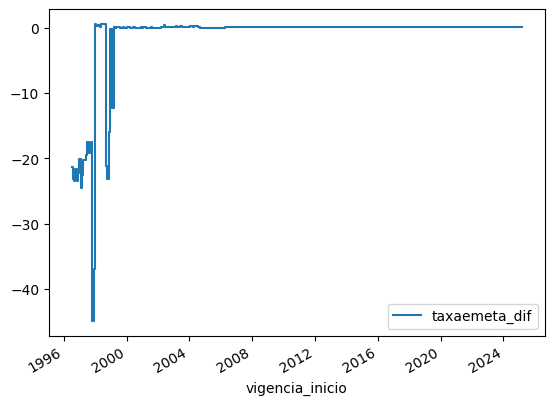

In [42]:
selic_df.plot(x = 'vigencia_inicio', y =  'taxaemeta_dif', drawstyle='steps-post')

Numa análise rápida, me parece que a partir de 1999, tivemos uma estabilização da diferença. E por volta de  2006, o valor tem estado constante. Para melhorar a análise, vamos limitar ao período 1996-1999 e depois 1999-2024.

<Axes: xlabel='vigencia_inicio'>

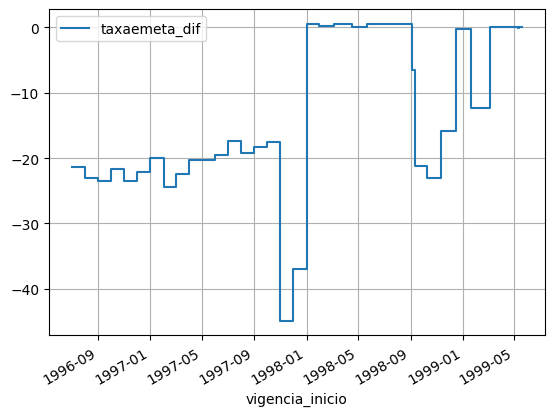

In [43]:
selic_df[selic_df['vigencia_inicio'] < '1999-06']\
    .plot(x = 'vigencia_inicio', y = 'taxaemeta_dif', drawstyle='steps-post', grid=True)

Até 1997, tínhamos a meta menor do que a taxa por volta de 20 pontos percentuais. No final de 1997, há uma queda vertiginosa que leva a diferença a mais de 40 pontos percentuais, que pode ser explicada pelo já comentado <a href='https://en.wikipedia.org/wiki/October_27,_1997,_mini-crash'>crash na bolsa de Hong Kong</a> (<a href = 'https://www1.folha.uol.com.br/fsp/1997/10/31/dinheiro/8.html'>ref</a>). Já em janeiro de 1998, a diferença cai para aproximadamente 0 e se mantém, variando ainda próximo de 0, até setembro de 1998, onde ocorre outra queda brusca fazendo a diferença chegar a 20 pontos percentuais. Depois de uma recuperação no final de dezembro de 1998 há uma queda para aproximadamente 12 pontos percentuais, mas logo a diferença volta a ser 0.  
Agora me pergunto o porquê dessa discrepância entre a meta e a taxa efetiva. Para melhorar o entendimento, vamos plotar os dados da meta e da taxa junto da taxaemeta_dif

<Axes: xlabel='vigencia_inicio'>

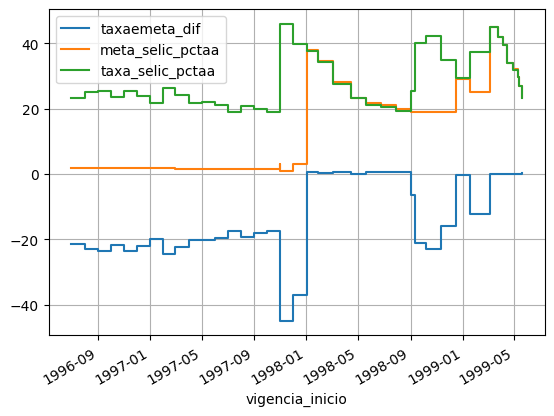

In [44]:
selic_df[selic_df['vigencia_inicio'] < '1999-06'].plot(
    x = 'vigencia_inicio', 
    y =  ['taxaemeta_dif', 'meta_selic_pctaa', 'taxa_selic_pctaa'], 
    drawstyle='steps-post', 
    grid=True
)

Até 1998, a meta não parecia servir de fato como meta, pois sempre havia uma defasagem de pelo menos 20 pontos percentuais. Só vemos a meta acompanhar a taxa a partir de janeiro de 1998 até setembro do mesmo ano, onde a defasagem atinge até um pouco mais de 20 pontos, só voltando a acompanhar a taxa em março de 99. O que será que explica esse desprendimento da meta e da taxa selic por tanto tempo?  
Voltando a página de onde retirei os <a href = 'https://www.bcb.gov.br/controleinflacao/historicotaxasjuros'></a> pude perceber um asterisco que passou desapercebido: 
* No período de 1/7/96 a 4/3/99, o COPOM fixava a TBC e, a partir de 5/3/99, com a extinção desta, passou a divulgar a meta para a Taxa SELIC para fins de política monetária.
* A partir de 2/01/98, as taxas de juros passaram a ser fixadas na expressão anual.   

Ou seja, não havia o conceito de Meta Selic, tal qual conhecemos hoje, antes de junho de 1999, como pode ser visto <a href= 'https://www.bcb.gov.br/pec/appron/Apres/200504PEP-Metas%20de%20Infla%E7%E3o%20e%20Evolu%E7%E3o%20da%20Taxa%20de%20C%E2mbio-Afonso%20Bevilaqua.pdf'>aqui</a>. Acho um grande erro colocar conceitos distintos em uma mesma coluna, mesmo que sinalizado. Para piorar, antes de janeiro de 1998, as taxas na tabela não eram anualizadas, levando a uma confusão.  Pesquisando mais a respeito da TBC, ela foi criada junto com a TBAN em 1996, segundo a <a href='https://www.bcb.gov.br/pec/boletim/Banual96/banualc2.asp?idpai=TARIFA&frame=1'> ata do copom de 1996</a>. Assim foi implementado pelo Copom o sistema de bandas de juros, onde TBAN era o teto e o TBC era o piso (<a href= 'https://www1.folha.uol.com.br/fsp/dinheiro/fi05039906.htm'>ref</a>).  
Vale ressaltar que o Copom foi instituído dia 20 de junho de 1996  com o objetivo de estabelecer as diretrizes da política monetária e de definir a taxa de juros (<a href = 'https://www.bcb.gov.br/htms/copom_normas/a-hist.asp?frame=1'>ref</a>), nos moldes de outros bancos centrais da Europa e dos EUA. A criação da TBC ocorreu dia 29 de maio de 1996 (<a href = 'https://www.bcb.gov.br/pre/normativos/circ/1996/pdf/circ_2698_v1_O.pdf'>ref</a>) enquanto que TBAN foi criada dia 21 de agosto de 1996 (<a href= 'https://normativos.bcb.gov.br/Lists/Normativos/Attachments/45791/Circ_2711_v1_O.pdf'>ref</a>) o que casa com os dados que temos. A Meta Selic, propriamente dita, foi estabelecida na reunião de <a href= 'https://www.bcb.gov.br/pre/normativos/circ/1999/pdf/circ_2868_v2_l.pdf'>4 de março de 1999</a>.  
Como a tabela está bagunçada por opção do BCB, vou mover os dados do tbam mensal para uma nova coluna

In [45]:
selic_df['tbc_pctam'] = selic_df.loc[selic_df['reuniao_data'] < '1999-03-04', 'meta_selic_pctaa']

In [46]:
selic_df.loc[selic_df['reuniao_data'] < '1999-03-04', 'meta_selic_pctaa'] = np.nan

Lembrando que os dados que retiramos da coluna meta_selic_pctaa estão parcialmente anualizados. Para fazer a distinção, alocamos para uma nova coluna tbc_pctaa os dados de a partir de 2 de janeiro de 1998. 

In [47]:
selic_df['tbc_pctaa'] = selic_df.loc[selic_df['vigencia_inicio'] >= '1998-01-02', 'tbc_pctam']
selic_df.loc[selic_df['vigencia_inicio'] >= '1998-01-02', 'tbc_pctam'] = np.nan
selic_df.tail()

,reuniao_num,reuniao_data,reuniao_vies,meta_selic_pctaa,tban_pctam,taxa_selic_pct,taxa_selic_pctaa,vigencia_inicio,vigencia_fim,data_comunicao_decisao_vies,taxaemeta_dif,tbc_pctam,tbc_pctaa
272,5ª,1996-10-23,n/a,NaN,1.90,1.80,25.27,1996-11-01,1996-11-30,NaT,-23.49,1.78,NaN
273,4ª,1996-09-23,n/a,NaN,1.93,1.86,23.48,1996-10-01,1996-10-31,NaT,-21.66,1.82,NaN
274,3ª,1996-08-21,n/a,NaN,NaN,1.90,25.40,1996-09-01,1996-09-30,NaT,-23.52,1.88,NaN
275,2ª,1996-07-30,n/a,NaN,NaN,1.97,25.01,1996-08-01,1996-08-31,NaT,-23.11,1.90,NaN
276,1ª,1996-06-26,n/a,NaN,NaN,1.93,23.28,1996-07-01,1996-07-31,NaT,-21.38,1.90,NaN


A divulgação do TBAN também foi anualizada a partir do mesmo dia

In [48]:
selic_df['tban_pctaa'] = selic_df.loc[selic_df['vigencia_inicio'] >= '1998-01-02', 'tban_pctam'] 
selic_df.loc[selic_df['vigencia_inicio'] >= '1998-01-02', 'tban_pctam'] = np.nan

We only need to correct the column taxaemeta_df

In [49]:
selic_df.loc[selic_df['reuniao_data'] < '1999-03-04', 'taxaemeta_dif'] = np.nan

We revisit the plot taxaemeta_dif

fig, axs = plt.subplots(1, 2, figsize = (15, 7), sharey = True)

selic_df.plot(x = 'vigencia_inicio',  y = 'taxaemeta_dif', drawstyle='steps-post', grid=True, ax = axs[0], label= 'Diferença meta e taxa')
axs[0].plot(selic_df.loc[:,'vigencia_inicio'], selic_df.loc[:,'taxaemeta_dif'].rolling(8).mean(), label= 'Média móvel da dif')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Pontos Percentuais')
axs[0].legend()

axs[1].fill_between(selic_df['vigencia_inicio'], selic_df['taxaemeta_dif'], step='post')
axs[1].plot(selic_df.loc[:,'vigencia_inicio'], selic_df.loc[:,'taxaemeta_dif'].rolling(8).std(), 'r-', label= 'Desvio padrão móvel')
axs[1].set_xlabel('Data')
axs[1].grid()
axs[1].legend()


fig.tight_layout()
plt.ylabel('Pontos percentuais')
plt.xlabel('Data')
plt.show()

Observamos que até o final de 2001, tivemos uma tendência de queda entre a diferença da meta e da taxa selic, saindo de um pouco abaixo de 0,1 até valores negativos, ou seja, a taxa chegou ficou acima da meta em algumas ocasiões, que segundo o BCB, foi devido a  alta da taxa de câmbio e o ritmo de crescimento da economia, que estava mais acelerado que o previsto (<a href = 'https://feeds.folha.uol.com.br/fsp/dinheiro/fi3103200102.htm'>ref</a>). Logo após, <a href= 'https://www1.folha.uol.com.br/folha/dinheiro/ult91u42790.shtml'>com a queda dos juros</a>, temos um tendência ascendente até atingir um pico (máximo global) que ultrapassa 0,4 pontos percentuais. No gráfico da direita, nesse período, temos um pico mais pronunciado no desvio padrão móvel, pois há uma maior oscilação entre valores negativos e positivos, indicando maior volatilidade. Depois desse pico, como podemos ver no primeiro gráfico, há uma queda brusca para abaixo de 0,15, mas logo a diferença volta a crescer para próximo de 0,2, permanecendo até o final de 2003.  A partir daí, há uma novo tombo, devido ao aumento gradual da taxa de juros (<a href="https://www.bcb.gov.br/pec/boletim/banual2004/rel2004introdp.pdf">ref. pág 11</a>), fazendo a taxa se aproximar da meta e, em algumas datas, até ultrapassar. Depois, temos um aumento em 2006, <a href='https://www1.folha.uol.com.br/fsp/dinheiro/fi2007200604.htm'>devido a queda no juros</a>, e a partir daí começa um período de menor variação até atingir, por volta de 2013, a estabilidade, onde a diferença fica contante, em 0,1 pontos percentuais. 

É muito curioso que antes de 2013 a diferença variava bastante e em um certo dia ela passou a ser constante. Do gráfico acima podemos facilmente encontrar que a partir do mês de abril de 2013, a diferença ficou em 0,1. Não encontrei nada que indicasse uma mudança que justificasse o estabelecimento da meta sempre acima da Selic over em 0,1. No entanto, sabendo que o BCB faz operações no mercado de modo que a Selic over fique alinhada a meta, me leva a pensar que o BCB passou a ser mais rígido em fazer a taxa ser fixa e fixada a 0,1 pontos percentuais abaixo da meta.

Segundo o site da <a href= 'https://t2.com.br/blog/selic-meta-x-selic-over/'>t2</a>, a diferença entre a meta e a selic é sempre 0,1 ou 0,11, daí me vem a dúvida de quantas vezes o valor foi 0,11.

In [51]:
selic_df.loc[np.isclose(selic_df['taxaemeta_dif'], 0.11), ['reuniao_data', 'vigencia_inicio', 'taxaemeta_dif']]

,reuniao_data,vigencia_inicio,taxaemeta_dif
98,2012-11-28,2012-11-29,0.11
99,2012-10-10,2012-10-11,0.11
100,2012-08-29,2012-08-30,0.11
101,2012-07-11,2012-07-12,0.11
102,2012-05-30,2012-05-31,0.11
223,2000-05-24,2000-05-25,0.11


Somente 6 vezes considerando toda a série histórica da meta selic e 5 vezes se considerarmos a partir da década passada como mais recente.

Notando que a diferença entre a meta e a taxa chegou a ser negativa, me pergunto quantas vezes isso ocorreu

In [52]:
print(f'{len(selic_df[selic_df["taxaemeta_dif"] < 0])} de um total de {len(selic_df[selic_df["reuniao_data"] >= "1999-03-04"])} períodos')

24 de um total de 237 períodos


Antes de prosseguir com a análise, me surgiu a curiosidade de se, durante o período de bandas de juros, a taxa selic chegou a ultrapassar esse limites. Vamos plotar

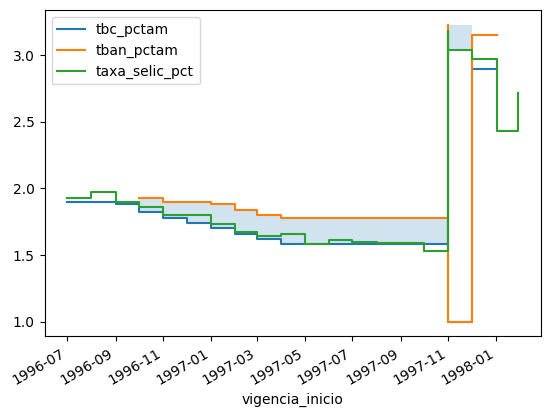

In [53]:
fig, ax = plt.subplots()
selic_df.plot(
    x = 'vigencia_inicio', 
    y =  ['tbc_pctam', 'tban_pctam'], 
    drawstyle='steps-post', 
    grid=True,
    ax = ax
)
selic_df[selic_df['vigencia_inicio'] < '02/01/98'].plot(
    x = 'vigencia_inicio', 
    y = 'taxa_selic_pct', 
    drawstyle='steps-post', 
    ax = ax)
ax.fill_between(selic_df['vigencia_inicio'], selic_df['tbc_pctam'], selic_df['tban_pctam'], alpha= .2, step='pre')

Temos um problema no mês onze de 1997. Isso, na verdade, já foi visto lá atrás e trata-se do problema de datas que tinhamos. 

In [54]:
selic_df[selic_df['reuniao_data'] ==  '1997-10-22'][['reuniao_data', 'tban_pctam', 'tbc_pctam']]

,reuniao_data,tban_pctam,tbc_pctam
260,1997-10-22,1.0,1.0


Estranhamente tban e o tbc estavam com a mesma taxa de juros. Pesquisando mais sobre essa reunião em específico, encontro que as taxas não entraram em vigor (<a href='https://centrodeeconomiapolitica.org/repojs/index.php/journal/article/download/414/404/787'>ref. pág. 443</a>). Vamos excluir essa linha 

In [55]:
selic_df = selic_df.drop(selic_df[selic_df['reuniao_data'] ==  '1997-10-22'].index, axis = 0)

Plotamos novamente o gráfico com as bandas de juros

[]

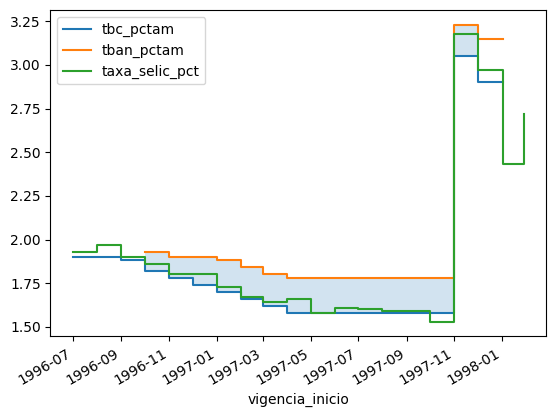

In [56]:
fig, ax = plt.subplots()
selic_df.plot(
    x = 'vigencia_inicio', 
    y =  ['tbc_pctam', 'tban_pctam'], 
    drawstyle='steps-post', 
    grid=True,
    ax = ax
)
selic_df[selic_df['vigencia_inicio'] < '02/01/98'].plot(
    x = 'vigencia_inicio', 
    y = 'taxa_selic_pct', 
    drawstyle='steps-post', 
    ax = ax)
ax.fill_between(selic_df['vigencia_inicio'], selic_df['tbc_pctam'], selic_df['tban_pctam'], alpha= .2, step='pre')
plt.plot()

A partir do gráfico acima, notamos que a taxa selic tendeu a ficar muito mais próxima da Taxa Básica do Banco Central (TBC) do que da Taxa de Assistência do Banco Central (TBAN), com exceção de novembro de 1997, onde houve o aumento da taxa selic devido a crise que se instalou com o crash da bolsa de Hong Kong. Além disso, o valor da taxa selic ficou pelo menos uma vez abaixo da banda inferior. Podemos conferir:

In [57]:
selic_df.query('taxa_selic_pct < tbc_pctam')

,reuniao_num,reuniao_data,reuniao_vies,meta_selic_pctaa,tban_pctam,taxa_selic_pct,taxa_selic_pctaa,vigencia_inicio,vigencia_fim,data_comunicao_decisao_vies,taxaemeta_dif,tbc_pctam,tbc_pctaa,tban_pctaa
261,16ª,1997-09-17,n/a,NaN,1.78,1.53,19.05,1997-10-01,1997-10-30,NaT,NaN,1.58,NaN,NaN


Por fim, vamos ver o período em que a TBAN e a TBC foram anualizadas

[]

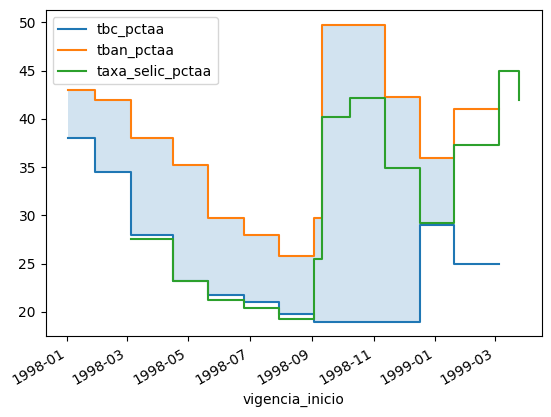

In [58]:
fig, ax = plt.subplots()
selic_df.plot(
    x = 'vigencia_inicio', 
    y =  ['tbc_pctaa', 'tban_pctaa'], 
    drawstyle='steps-post', 
    grid=True,
    ax = ax
)
selic_df.query('vigencia_inicio > "02/01/98" & vigencia_inicio < "4/3/99"').plot(
    x = 'vigencia_inicio', 
    y = 'taxa_selic_pctaa', 
    drawstyle='steps-post', 
    ax = ax)
ax.fill_between(selic_df['vigencia_inicio'], selic_df['tbc_pctaa'], selic_df['tban_pctaa'], alpha= .2, step='pre')
plt.plot()

No período em que as taxas foram anualizadas, notamos que a taxa Selic ficou abaixo do piso de juros, indicando que as bandas não foram efetivas em delimitar os juros. Vamos contar quantas vezes a taxa ficou fora das bandas.

In [59]:
len(selic_df.query('taxa_selic_pctaa < tbc_pctaa | tban_pctaa < taxa_selic_pctaa'))

7

7 vezes em um curto período de tempo.

Vamos salvar os dados transformados em um csv.

In [60]:
selic_df.to_csv('dados/selic_transformacao_preliminar.tsv', sep = '\t')

Voltando ao objeto de minha análise que é a taxa selic, percebemos que os dados estão espaçados não uniformemente, o que é requisito para poder associar com os dados do IPCA. De modo a resolver esse problema, vamos mensalizar os dados. Para isso, primeiro notamos que os dados da selic anual são anualizados considerando dias úteis em um ano, daí vem padrão usado pelo BCB que é um ano tem 252 dias úteis. Logo, uma forma de fazer a transformação é diarizar os dados considerando os mesmos 252 dias, e depois calculamos o acumulado mensal considerando os dias úteis de cada mês. Vamos fazer isso para meta e para a selic (over).

In [61]:
resampled_selic_df = selic_df[['vigencia_inicio', 'taxa_selic_pctaa', 'meta_selic_pctaa']]\
    .set_index('vigencia_inicio')\
    .apply(lambda x: np.power(1 + x/100, 1/252))\
    .resample('B')\
    .ffill()

resampled_selic_df.tail()

,taxa_selic_pctaa,meta_selic_pctaa
vigencia_inicio,,
2025-03-14,1.00049,1.000494
2025-03-17,1.00049,1.000494
2025-03-18,1.00049,1.000494
2025-03-19,1.00049,1.000494
2025-03-20,NaN,1.000529


Para mensalizarmos, além de excluir sábados e domingos, temos também que excluir feriados.

Feriados é o que não é considerado dia útil e para o <a href="https://www.bcb.gov.br/cidadaniafinanceira/direitosdeveres"> BCB</a>, esses dias são:

* Segunda-feira e terça-feira de Carnaval
* 2 de novembro
* Último dia útil do ano *

*Como há operações entre as próprias instituições financeiras no último dia do ano, então consideramos ele útil.

Esses dias não úteis podem ser encontrados no arquivo feriados.csv

In [62]:
feriados_df = pd.read_csv('dados/feriados.csv')

In [63]:
for feriado in feriados_df:
    feriados_df[feriado] = pd.to_datetime(feriados_df[feriado])

In [64]:
feriados_df = feriados_df.unstack().to_frame().set_index(0)

Mensalizamos a taxa selic diária com o filtro criado usando o dicionário de feriados.

In [65]:
selic_mensal_df = resampled_selic_df[~resampled_selic_df.index.isin(feriados_df.index)]\
    .resample('M')\
    .prod()\
    .apply(lambda x: (x - 1) * 100)
selic_mensal_df = selic_mensal_df.iloc[:-1, :]
selic_mensal_df.head()

,taxa_selic_pctaa,meta_selic_pctaa
vigencia_inicio,,
1996-07-31,1.928529,0.0
1996-08-31,1.967890,0.0
1996-09-30,1.904054,0.0
1996-10-31,1.943610,0.0
1996-11-30,1.895246,0.0


Desconsiderei o último valor pois o mês pode não ter fechado ainda.

Como o indice não representa uma data específica e sim um periodo, vamos mudar a coluna para periodo e renomeá-la.

In [66]:
selic_mensal_df.index = selic_mensal_df.index.to_period()
selic_mensal_df = selic_mensal_df.reset_index()
selic_mensal_df = selic_mensal_df.rename(columns = {
    'vigencia_inicio': 'periodo_mes',
    'meta_selic_pctaa': 'meta_acumulada_mes', 
    'taxa_selic_pctaa': 'selic_acumulada_mes'
})
selic_mensal_df.head()

,periodo_mes,selic_acumulada_mes,meta_acumulada_mes
0,1996-07,1.928529,0.0
1,1996-08,1.967890,0.0
2,1996-09,1.904054,0.0
3,1996-10,1.943610,0.0
4,1996-11,1.895246,0.0


Da tabela acima, a coluna meta_acumulada_mes apresenta como taxa o número 0 em datas onde ela não existia. Isso se deve às transformações feitas na obtenção dos valores mensais. Para lidar com isso, vamos mudar esse valor para NaN.

In [67]:
selic_mensal_df['meta_acumulada_mes'] = selic_mensal_df['meta_acumulada_mes'].replace(0, np.nan)

Fazemos também uma tabela anual (para representar o acumulado no ano)

In [68]:
selic_anual_df = resampled_selic_df[~resampled_selic_df.index.isin(feriados_df.index)]\
    .resample('Y')\
    .prod()\
    .apply(lambda x: (x - 1) * 100)
selic_anual_df = selic_anual_df.reset_index()
selic_anual_df = selic_anual_df.rename(columns = {
    'vigencia_inicio': 'ano',
    'taxa_selic_pctaa': 'selic_acumulada_ano',
    'meta_selic_pctaa': 'meta_acumulada_ano'
})
selic_anual_df['ano'] = selic_anual_df['ano'].dt.year
selic_anual_df = selic_anual_df.iloc[:-1, :]
selic_anual_df['meta_selic_ano'] = selic_anual_df['meta_acumulada_ano'].replace(0, np.nan)
selic_anual_df.head()

,ano,selic_acumulada_ano,meta_acumulada_ano,meta_selic_ano
0,1996,12.099091,0.000000,NaN
1,1997,25.463435,0.000000,NaN
2,1998,30.041154,0.000000,NaN
3,1999,26.552702,20.276692,20.276692
4,2000,17.947014,17.965603,17.965603


<hr>

<h3><span id='IPCA'></span>2. IPCA</h3>

It is time to extract the IPCA data (Inflation rate). They can be found on <a href= 'https://ftp.ibge.gov.br/Precos_Indices_de_Precos_ao_Consumidor/IPCA/Serie_Historica/ipca_SerieHist.zip'>IBGE website</a>

In [21]:
import requests
from io import BytesIO
from zipfile import ZipFile

In [70]:
ipca_url = "https://ftp.ibge.gov.br/Precos_Indices_de_Precos_ao_Consumidor/IPCA/Serie_Historica/ipca_SerieHist.zip"
file = requests.get(ipca_url).content
file_bytes = BytesIO(file)

unzipped = ZipFile(file_bytes)
ipca_file = unzipped.namelist()[0]

In [71]:
ipca_df = pd.read_excel(BytesIO(unzipped.read(ipca_file)))
ipca_df.head(10)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,SÉRIE HISTÓRICA DO IPCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(continua)
2,NaN,NaN,NaN,NaN,NaN,VARIAÇÃO,NaN,NaN
3,ANO,MÊS,NÚMERO ÍNDICE,(%),NaN,NaN,NaN,NaN
4,NaN,NaN,(DEZ 93 = 100),NO,3,6,NO,12
5,NaN,NaN,NaN,MÊS,MESES,MESES,ANO,MESES
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1994,JAN,141.31,41.31,162.13,533.33,41.31,2693.84
8,NaN,FEV,198.22,40.27,171.24,568.17,98.22,3035.71
9,NaN,MAR,282.96,42.75,182.96,602.93,182.96,3417.39


In [ ]:
We can see that the formatting is not good. 

Devido a como os dados estão dispostos na planilha de excel com uma formatação não muito amigável, as linhas da tabela estão desorganizadas e cheias de NaNs. Entretanto, é possível notar que cada linha que contém os dados de interessa, tem no máximo um NaN. Dessa forma podemos usar essa lógica como filtro.

In [72]:
ipca_df = ipca_df[ipca_df.isnull().sum(axis = 'columns') <= 1].reset_index(drop=True)
ipca_df_cols = [
    'ano',
    'mes',
    'ipca_numero_indice',
    'ipca_var_mensal',
    'ipca_var_trimestral',
    'ipca_var_semetral',
    'ipca_no_ano',
    'ipca_acumulado_ano'
]
ipca_df.columns = ipca_df_cols
ipca_df.head()

,ano,mes,ipca_numero_indice,ipca_var_mensal,ipca_var_trimestral,ipca_var_semetral,ipca_no_ano,ipca_acumulado_ano
0,1994,JAN,141.31,41.31,162.13,533.33,41.31,2693.84
1,NaN,FEV,198.22,40.27,171.24,568.17,98.22,3035.71
2,NaN,MAR,282.96,42.75,182.96,602.93,182.96,3417.39
3,NaN,ABR,403.73,42.68,185.71,648.92,303.73,3828.49
4,NaN,MAI,581.49,44.03,193.36,695.71,481.49,4331.19


Dá para perceber que temos alguns dados nulos na coluna ano. Vamos ver se há mais em outras colunas.

In [73]:
ipca_df.isnull().sum()[ipca_df.isnull().sum() > 0]

ano    342
dtype: int64

Only one year. We will forward fill the missing years  

In [74]:
ipca_df['ano'] = ipca_df['ano'].ffill().astype('str')
ipca_df.head()

,ano,mes,ipca_numero_indice,ipca_var_mensal,ipca_var_trimestral,ipca_var_semetral,ipca_no_ano,ipca_acumulado_ano
0,1994,JAN,141.31,41.31,162.13,533.33,41.31,2693.84
1,1994,FEV,198.22,40.27,171.24,568.17,98.22,3035.71
2,1994,MAR,282.96,42.75,182.96,602.93,182.96,3417.39
3,1994,ABR,403.73,42.68,185.71,648.92,303.73,3828.49
4,1994,MAI,581.49,44.03,193.36,695.71,481.49,4331.19


<h4><span id='SobreIPCA'></span>About the dataset: IPCA</h4>

| Variable   | Description                                                                                                |
|-----------------------|-------------------------------------------------------------------------------------------|
| ano                   | 4-digit numeric year.                                                            |
| mes                   | The first three letters of the respective month                     |
| ipca_numero_indice    | Weighted arithmetic average of the 16 monthly average Brazillian metropolitan indeces, computed using the Laspeyres Formula |
| ipca_var_mensal       | Monthly variation of the IPCA index over a month     |
| ipca_var_trimestral   | Quarterly variation of the index considering the last 3 months  |
| ipca_var_semetral     | Six-month change in the index over the last 6 months. |
| ipca_no_ano           | IPCA index variation in the reference month compared to the index in December of the previous year, for the reference year. |
ipca_acumulado_ano    | Annual variation sum over 12 months                                              | 

The monthly IPCA index variation is the Brazillian inflation rate

Let's check the types

In [75]:
ipca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ano                  374 non-null    object
 1   mes                  374 non-null    object
 2   ipca_numero_indice   374 non-null    object
 3   ipca_var_mensal      374 non-null    object
 4   ipca_var_trimestral  374 non-null    object
 5   ipca_var_semetral    374 non-null    object
 6   ipca_no_ano          374 non-null    object
 7   ipca_acumulado_ano   374 non-null    object
dtypes: object(8)
memory usage: 23.5+ KB


In [76]:
dfcols_type(ipca_df)

{'ano': {str},
 'mes': {str},
 'ipca_numero_indice': {float, int},
 'ipca_var_mensal': {float, int},
 'ipca_var_trimestral': {float, int},
 'ipca_var_semetral': {float, int},
 'ipca_no_ano': {float, int},
 'ipca_acumulado_ano': {float, int}}

As we can see, we have only two columns that are not mixed types. Before casting each column to their respective correct type, we will create a new mes (month) column where the months are the three-first-letters string.

In [77]:
meses_numcap = {
    'JAN': '1',
    'FEV': '2',
    'MAR': '3',
    'ABR': '4',
    'MAI': '5',
    'JUN': '6',
    'JUL': '7',
    'AGO': '8',
    'SET': '9',
    'OUT': '10',
    'NOV': '11',
    'DEZ': '12'
}

In [78]:
ipca_df['mes_num'] = ipca_df['mes'].map(meses_numcap)
ipca_df['periodo_mes'] = ipca_df['ano'] + '-' + ipca_df['mes_num']

ipca_df['periodo_mes'] = pd.PeriodIndex(ipca_df['periodo_mes'], freq='M')
ipca_df.head()

,ano,mes,ipca_numero_indice,ipca_var_mensal,ipca_var_trimestral,ipca_var_semetral,ipca_no_ano,ipca_acumulado_ano,mes_num,periodo_mes
0,1994,JAN,141.31,41.31,162.13,533.33,41.31,2693.84,1,1994-01
1,1994,FEV,198.22,40.27,171.24,568.17,98.22,3035.71,2,1994-02
2,1994,MAR,282.96,42.75,182.96,602.93,182.96,3417.39,3,1994-03
3,1994,ABR,403.73,42.68,185.71,648.92,303.73,3828.49,4,1994-04
4,1994,MAI,581.49,44.03,193.36,695.71,481.49,4331.19,5,1994-05


We set the data types for numeric values.

In [79]:
for ii in range(len(ipca_df.columns) - 1):
    if ii == 1:
        continue
    ipca_df[ipca_df.columns[ii]] = pd.to_numeric(ipca_df[ipca_df.columns[ii]])
ipca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype    
---  ------               --------------  -----    
 0   ano                  374 non-null    int64    
 1   mes                  374 non-null    object   
 2   ipca_numero_indice   374 non-null    float64  
 3   ipca_var_mensal      374 non-null    float64  
 4   ipca_var_trimestral  374 non-null    float64  
 5   ipca_var_semetral    374 non-null    float64  
 6   ipca_no_ano          374 non-null    float64  
 7   ipca_acumulado_ano   374 non-null    float64  
 8   mes_num              374 non-null    int64    
 9   periodo_mes          374 non-null    period[M]
dtypes: float64(6), int64(2), object(1), period[M](1)
memory usage: 29.3+ KB


We rename the column ipca_var_mensal so we can shortten it to only ipca_mes

In [80]:
ipca_df = ipca_df.rename(columns =  {
    'ipca_var_mensal' : 'ipca_mes'
})

We create the decada (decade) column 

In [81]:
ipca_df['decada'] = (np.floor(ipca_df['ano'] / 10) * 10).astype('int')
ipca_df['decada']

0      1990
1      1990
2      1990
3      1990
4      1990
       ... 
369    2020
370    2020
371    2020
372    2020
373    2020
Name: decada, Length: 374, dtype: int32

We can now limit the features to the features of interes.

In [82]:
ipca_mensal_df = ipca_df[['periodo_mes', 'mes', 'ano', 'decada' ,'ipca_mes']]
ipca_mensal_df.head()

,periodo_mes,mes,ano,decada,ipca_mes
0,1994-01,JAN,1994,1990,41.31
1,1994-02,FEV,1994,1990,40.27
2,1994-03,MAR,1994,1990,42.75
3,1994-04,ABR,1994,1990,42.68
4,1994-05,MAI,1994,1990,44.03


We created the yearly version

In [83]:
ipca_anual_df = ipca_df.groupby('ano')[['ipca_acumulado_ano', 'decada']].last().reset_index()

<hr></hr>
We merge the selic and the ipca monthly data

In [84]:
merged_mensal_df = selic_mensal_df.merge(ipca_mensal_df, how='inner', on='periodo_mes')
merged_mensal_df.head()

,periodo_mes,selic_acumulada_mes,meta_acumulada_mes,mes,ano,decada,ipca_mes
0,1996-07,1.928529,NaN,JUL,1996,1990,1.11
1,1996-08,1.967890,NaN,AGO,1996,1990,0.44
2,1996-09,1.904054,NaN,SET,1996,1990,0.15
3,1996-10,1.943610,NaN,OUT,1996,1990,0.30
4,1996-11,1.895246,NaN,NOV,1996,1990,0.32


In [85]:
merged_mensal_df = merged_mensal_df[[
    'periodo_mes', 
    'mes', 
    'ano', 
    'decada', 
    'meta_acumulada_mes', 
    'selic_acumulada_mes', 
    'ipca_mes'
]]

We save as a tsv file.

In [86]:
merged_mensal_df.to_csv('dados/selic_ipca_mes.tsv', sep = '\t', index =  False)

We do the same for the ipca.

In [87]:
merged_anual_df = selic_anual_df.merge(
    ipca_anual_df, how='inner', on='ano', 
)

In [88]:
merged_anual_df = merged_anual_df[['ano', 'decada', 'meta_selic_ano', 'selic_acumulada_ano', 'ipca_acumulado_ano']]

In [89]:
merged_anual_df.to_csv('dados/selic_ipca_ano.tsv', sep = '\t', index = False)